# Intro to scvi -- test Feb 16 2026

Using quick start at https://docs.scvi-tools.org/en/1.2.2/tutorials/notebooks/quick_start/api_overview.html

Use scvi kernel

In [1]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch

/Users/jb_alberge/scvi-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.1


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = "."

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# download data

In [4]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir)
adata

INFO     Downloading file at ./hca_subsampled_20k.h5ad                                                             
Downloading...: 100%|████████████████████████████████████████████████████████| 65714/65714.0 [00:00<00:00, 70829.66it/s]


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

# preprocess

filter

In [7]:
sc.pp.filter_genes(adata, min_counts=3)

normalize

In [8]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

feature selection

In [9]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

register model

In [10]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

# create and train model

In [9]:
model = scvi.model.SCVI(adata)

In [10]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [11]:
model.train(accelerator='mps') # mps for macbook's gpu and workers for parallel loading

/Users/jb_alberge/scvi-env/lib/python3.12/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usual. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/jb_alberge/scvi-env/lib/python3.12/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/Users/jb_alberge/scv

Epoch 400/400: 100%|█████████████████████████████████████████| 400/400 [07:24<00:00,  1.16s/it, v_num=1, train_loss=284]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████████████████████████████████| 400/400 [07:24<00:00,  1.11s/it, v_num=1, train_loss=284]


# save

In [27]:
model_dir = os.path.join(save_dir, "scvi_model")
model.save(model_dir, overwrite=True)

In [11]:
#model_dir = "scvi_model"
model = scvi.model.SCVI.load(model_dir, adata=adata)

INFO     File scvi_model/model.pt already downloaded                                                               


/Users/jb_alberge/scvi-env/lib/python3.12/site-packages/scvi/model/base/_base_model.py:857: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


# obtaining model outputs

In [12]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(18641, 10)

## subset

In [13]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(adata_subset)
latent.shape
#latent_subset.shape

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(18641, 10)

In [14]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.417351,0.003396,1.106435,0.058623,3.835453
GAGTCATTCTCCGTGT-1-HCAHeart8287128,0.936470,0.015499,2.536425,0.011680,37.319305
CCTCTGATCGTGACAT-1-HCAHeart7702881,1.011192,0.022800,3.384954,0.005896,3.666893
CGCCATTCATCATCTT-1-H0035_apex,0.240776,0.064209,0.522814,0.019556,5.540027
TCGTAGAGTAGGACTG-1-H0015_septum,0.636880,0.000720,0.270128,0.132475,13.640639


save normalized values

In [15]:
SCVI_NORMALIZED_KEY = "scvi_normalized"

adata.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size=10e4)

# batch corrected space

In [16]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

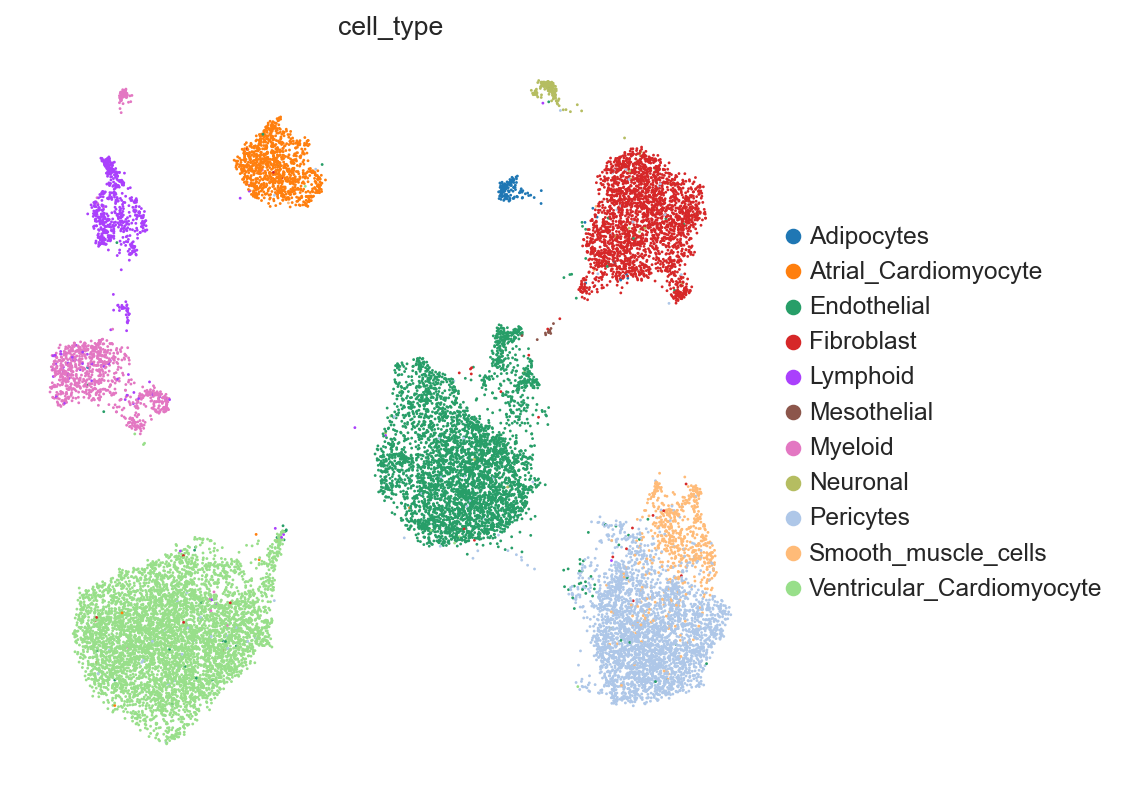

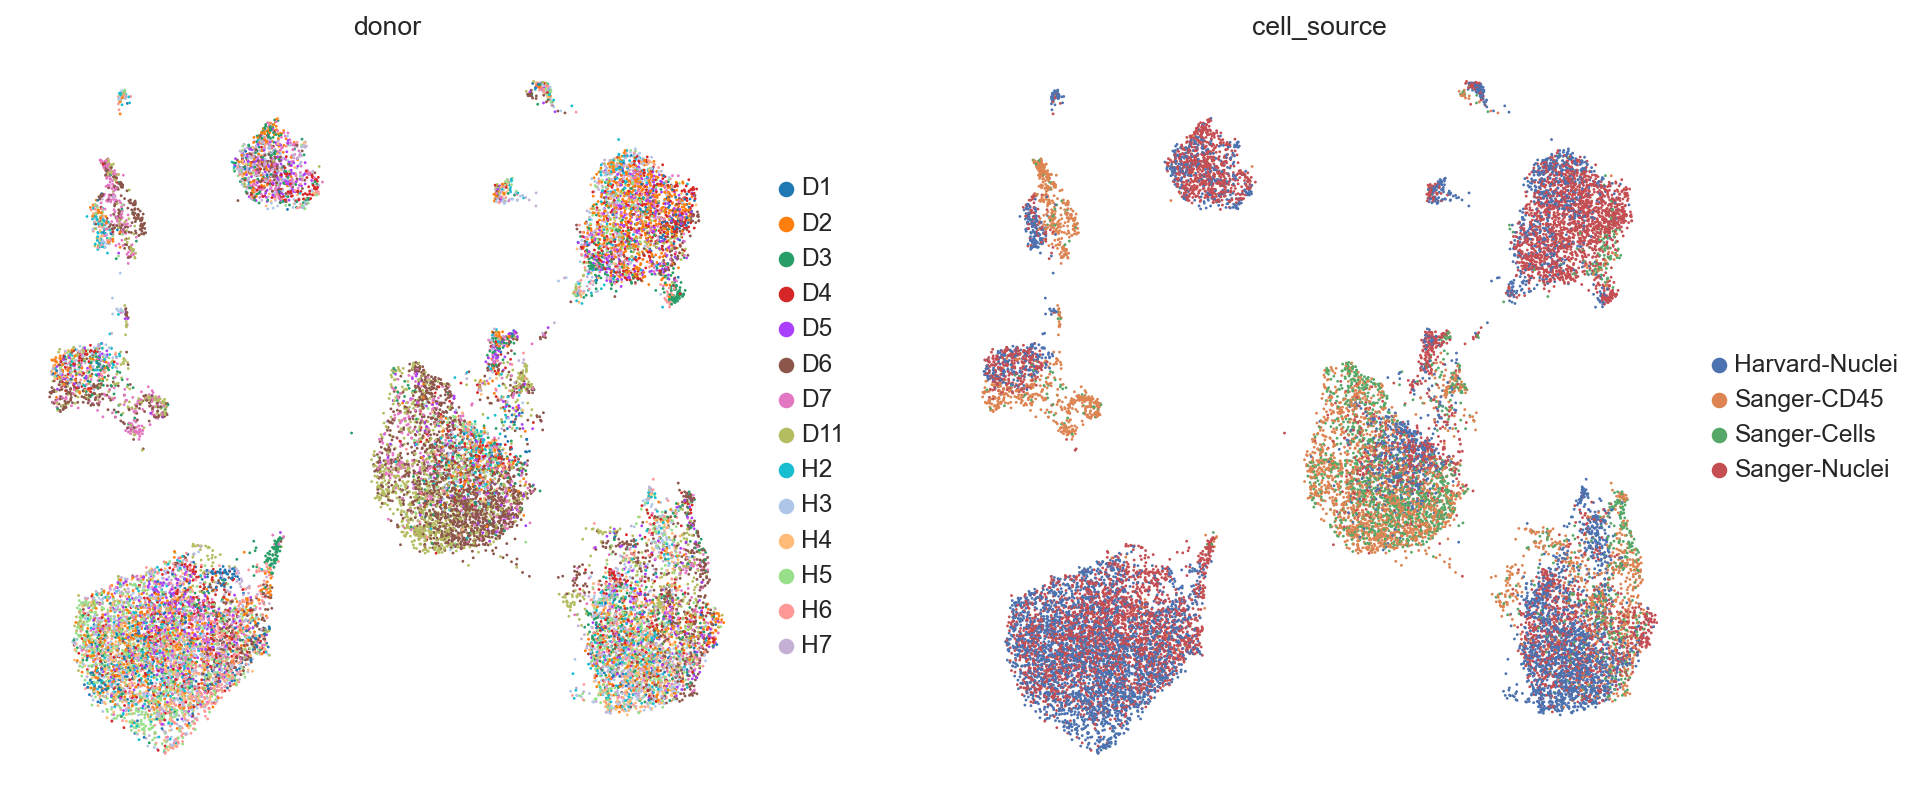

In [17]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

# clustering

In [21]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5, flavor="igraph")

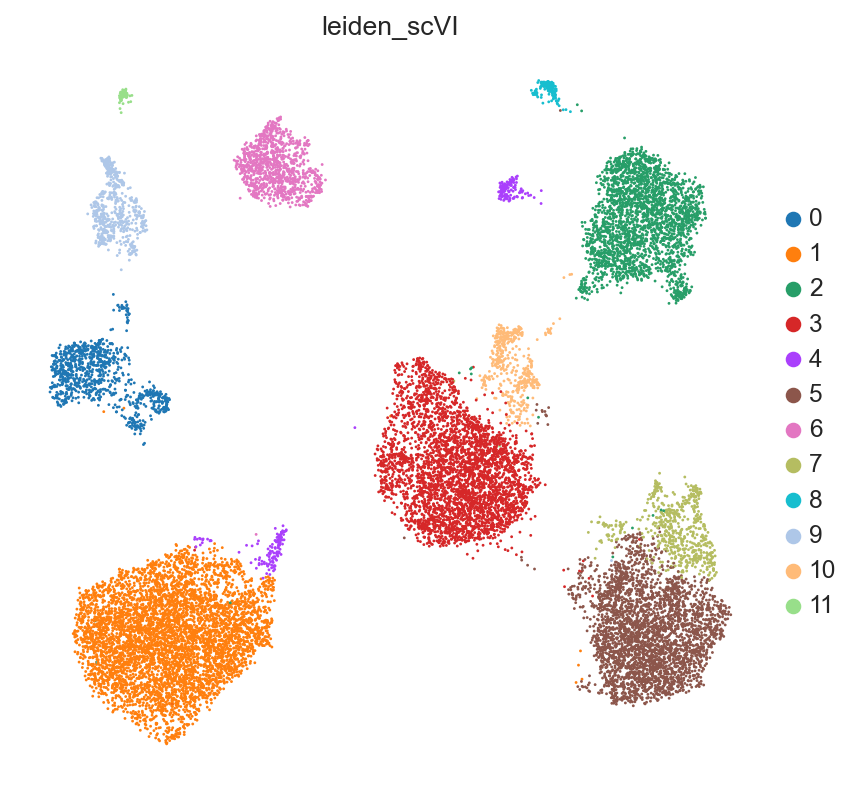

In [22]:
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)

# differential

In [23]:
adata.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ..., 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']

In [24]:
de_df = model.differential_expression(
    groupby="cell_type", group1="Endothelial", group2="Fibroblast"
)
de_df.head()

DE...: 100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.13it/s]


,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2
EGFL7,0.9984,0.0016,6.436144,0.007166,0.000406,2.376779,0.036795,0.741543,0.025756,89.507553,1.169474,Endothelial vs Fibroblast,Endothelial,Fibroblast
SLC9A3R2,0.9974,0.0026,5.949637,0.010775,0.000177,4.451492,0.045380,0.712339,0.034342,111.582703,1.657324,Endothelial vs Fibroblast,Endothelial,Fibroblast
VWF,0.9962,0.0038,5.568944,0.014950,0.000695,5.072563,0.054375,0.808226,0.032298,169.693512,2.207696,Endothelial vs Fibroblast,Endothelial,Fibroblast
PECAM1,0.9948,0.0052,5.253881,0.005188,0.000765,2.065984,0.075634,0.653930,0.054374,60.612019,3.404117,Endothelial vs Fibroblast,Endothelial,Fibroblast
SOX17,0.9932,0.0068,4.984008,0.001774,0.000067,0.784371,0.006541,0.307617,0.004497,17.128170,0.185868,Endothelial vs Fibroblast,Endothelial,Fibroblast


## 1 vs all

In [25]:
de_df = model.differential_expression(
    groupby="cell_type",
)
de_df.head()

DE...: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.35it/s]


,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2
DGAT2,0.9984,0.0016,6.436144,0.003407,0.000038,2.682757,0.005028,0.593103,0.004866,43.613537,0.194096,Adipocytes vs Rest,Adipocytes,Rest
GYG2,0.9982,0.0018,6.318161,0.002089,0.000027,1.386207,0.002649,0.462069,0.002595,22.767191,0.110073,Adipocytes vs Rest,Adipocytes,Rest
PLIN1,0.9982,0.0018,6.318161,0.004183,0.000046,2.799999,0.004379,0.806897,0.004325,52.921761,0.196486,Adipocytes vs Rest,Adipocytes,Rest
GPAM,0.9978,0.0022,6.117091,0.017522,0.000185,17.372416,0.035791,0.896552,0.031520,280.340485,1.565905,Adipocytes vs Rest,Adipocytes,Rest
PTPRF,0.9972,0.0028,5.875328,0.002443,0.000075,1.468965,0.011300,0.600000,0.010651,26.615402,0.438129,Adipocytes vs Rest,Adipocytes,Rest


## extract top N

In [27]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for c in cats:
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]

    #cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [28]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

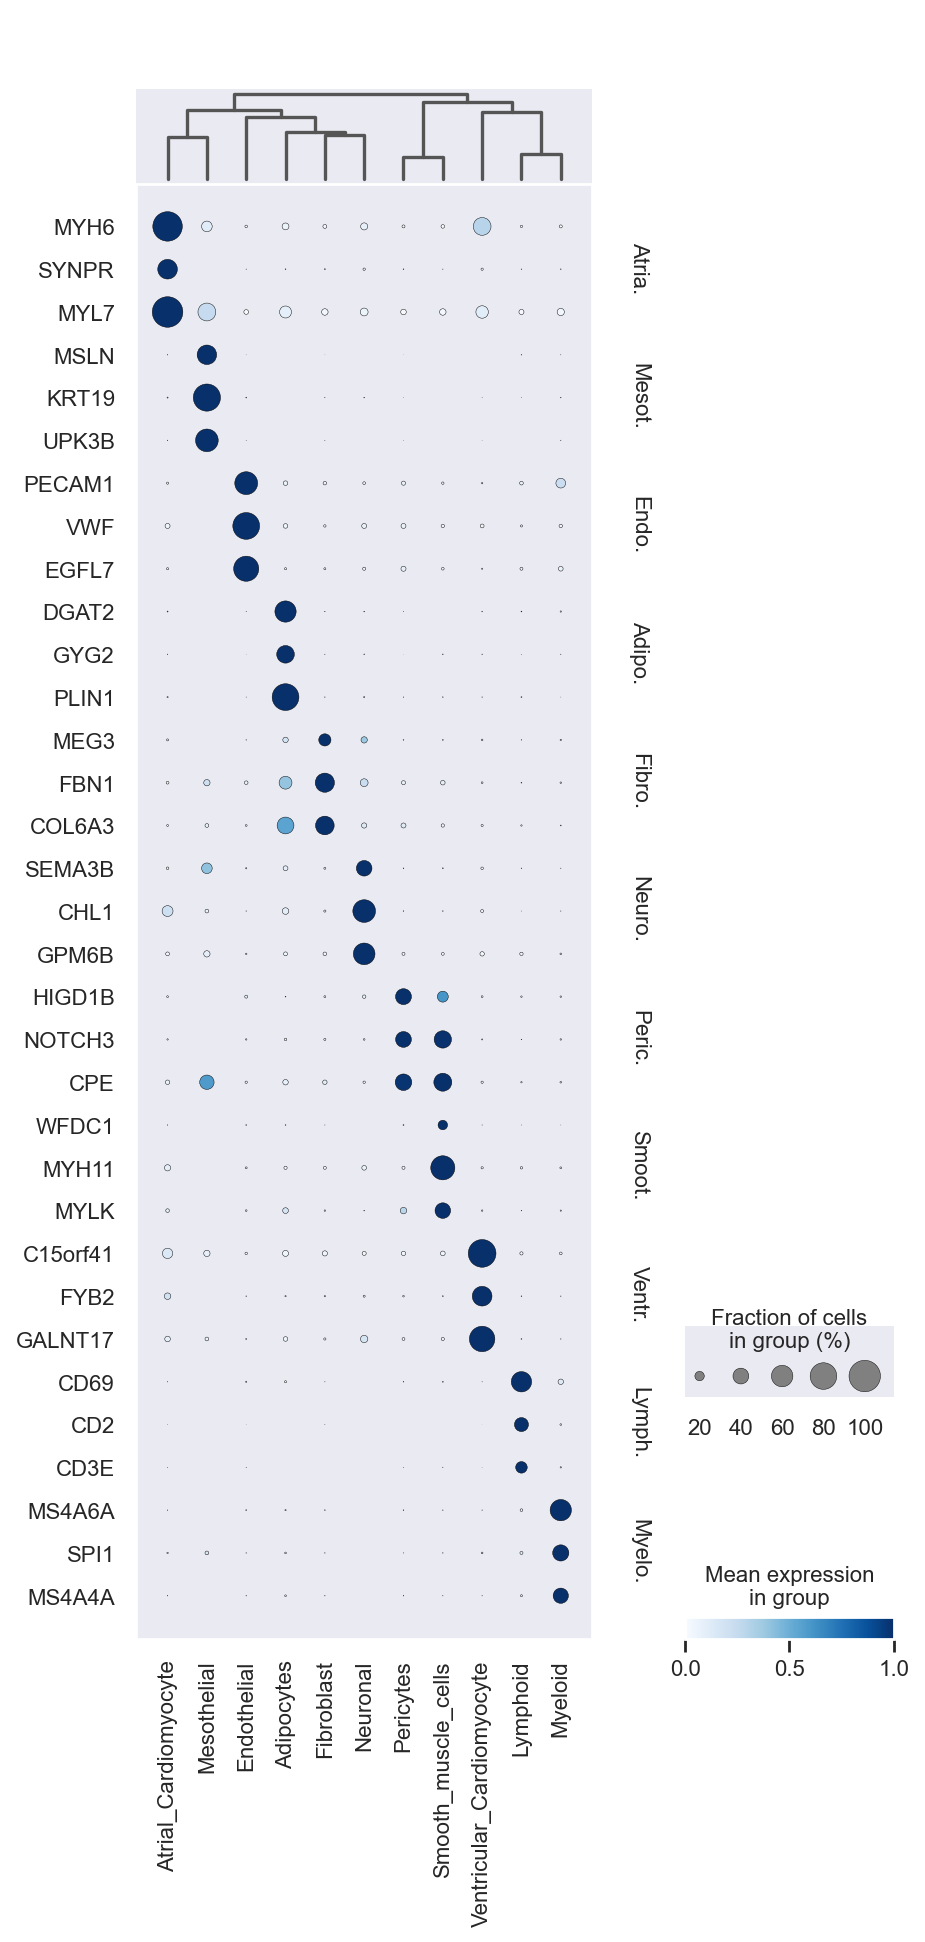

In [29]:
sc.pl.dotplot(
    adata,
    markers,
    groupby="cell_type",
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

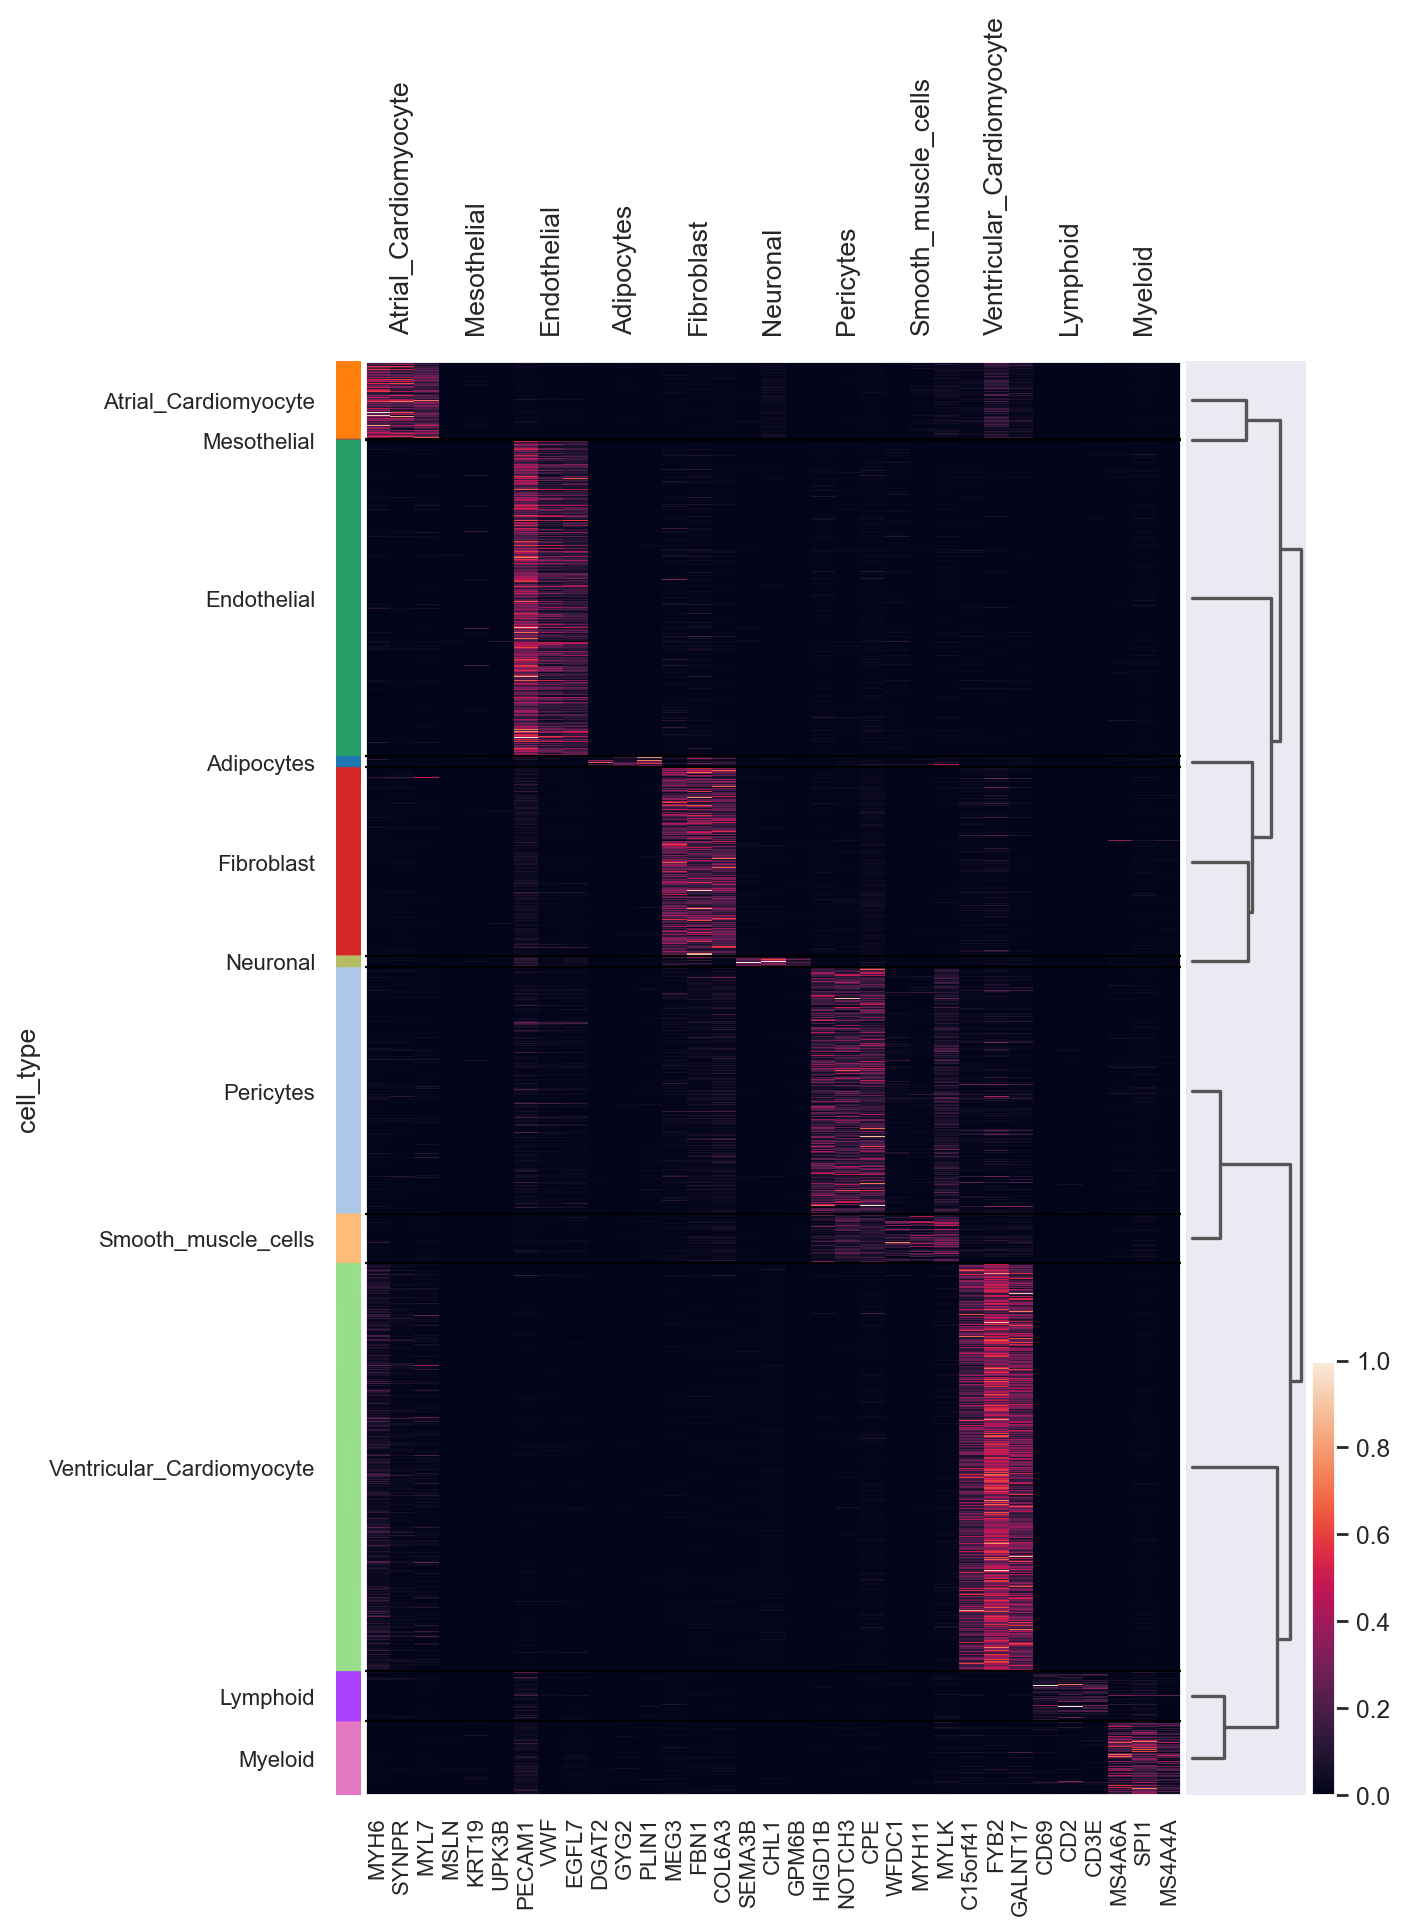

In [30]:
sc.pl.heatmap(
    adata,
    markers,
    groupby="cell_type",
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12),
)